# Data Formatting

## Player data input and format

### Imports
First I import the necessary libraries, including custom functions

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from analysis_functions import loader, player_id2player, stats_conv, team_id2team, best_version
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from itertools import chain

### Positions to colours
Then I create a dictionary relating positions to colours, for use in graphs later

In [2]:
colour_dict = {
    'GK': 'red',
    'CB': 'orangered',
    'LB': 'darkorange',
    'RB': 'coral',
    'CDM': 'gold',
    'CM': 'yellow',
    'RW': 'limegreen',
    'LW': 'greenyellow',
    'ST': 'green'
}

### Importing data
Here I import the data, using custom functions to load the match, player and team data from the csv files into python dictionaries

In [3]:
season = '25_26'
version = best_version(season)
players, matches, teams = loader(version, season)

### Creating player stats dictionary
Here I add each player's match data to their dictionary of stats, including calculating some new stats using existing ones

In [4]:
# match stats to be recorded
stats = ["MinutesPlayed", "MatchRating", "GoalsConceded", "OwnGoals", "Goals", "Assists", "Shots", "ShotsOnTarget", "PenaltiesTaken", "PenaltiesScored", "PenaltiesConceded", "xG", "xA", "Passes", "PassesCompleted", "Possession", "PossessionWon", "PossessionLost", "YellowCards", "RedCards"]
# gk match stats to be recorded
gk_stats = ["ShotsFaced", "Saves", "PenaltiesFaced", "PenaltiesSaved"]
# iterating through every player in the player data
for player in players:
    player["Appearances"] = 0
    for stat in stats:
        player[stat] = 0
    for stat in gk_stats:
        player[stat] = 0
    for position in ["GK", "RB", "CB", "LB", "CDM", "CM", "RW", "ST", "LW"]:
        player[f'MinutesAs{position}'] = 0
    for comp, matchs in matches.items():
        # getting all the mathces for each competition
        for match in matchs:
            # for every match in the competition
            for section in [match['Teams']['Barcelona']['Players']['Lineup'], match['Teams']['Barcelona']['Players']['Bench']]:
                for person in section:
                    # for every player in the lineup and bench
                    if person['PlayerId'] == player['Id']:
                        # if the match data is for the player being looked at in the current iteration (of the original for loop)
                        if person['MinutesPlayed'] > 0:
                            player["Appearances"] += 1
                        for stat in stats:
                            if person[stat]:
                                player[stat] += person[stat]
                        if person['Goalkeeping']:
                            for stat in gk_stats:
                                player[stat] += person["Goalkeeping"][stat]  
                        if len(person['PositionsPlayed']) == 1:
                            position = person['PositionsPlayed'][0]
                            player[f'MinutesAs{position}'] += person['MinutesPlayed']
                        elif len(person['PositionsPlayed']) > 1:
                            position = person['PositionsPlayed'][0]
                            player[f'MinutesAs{position}'] += round((person['MinutesPlayed'] * 2/3), 0)
                            position = person['PositionsPlayed'][1]
                            player[f'MinutesAs{position}'] += round((person['MinutesPlayed'] * 1/3), 0)
    if player['Position'] != 'GK':
        for stat in gk_stats:
            player[stat] = None
    # creating per 90 stats
    for stat in stats:
        statp90 = f'{stat}p90'
        if player['MinutesPlayed'] != 0:
            player[statp90] = round(((player[stat]/player['MinutesPlayed']) * 90), 2)
        else:
            player[statp90] = 0
    if player['Position'] == 'GK':
        for stat in gk_stats:
            statp90 = f'{stat}p90'
            if player['MinutesPlayed'] != 0:
                player[statp90] = round(((player[stat]/player['MinutesPlayed']) * 90), 2)
            else:
                player[statp90] = 0
    # creating pass completion, shot accuracy, shot conversion, goals-xG, assists-xA, xG per shot, Goal contributions (and per 90), xGC (and per 90)
    # minutes played per game and possession won and lost per percentage possession stats
    player['PassCompletion'] = 0
    if player['Passes'] > 0:
        player['PassCompletion'] = round((player['PassesCompleted'] / player['Passes']), 2)
    player['ShotAccuracy'] = 0
    if player['Shots'] > 0:
        player['ShotAccuracy'] = round((player['ShotsOnTarget'] / player['Shots']), 2)
    player['Goals-xG'] = round((player['Goals'] - player['xG']), 2)
    player['Assists-xA'] = round((player['Assists'] - player['xA']), 2)
    player['Goals-xGp90'] = 0
    if player['Goals-xG'] > 0:
        player['Goals-xGp90'] = round((player['Goals-xG'] / player['MinutesPlayed']) * 90, 2)
    player['Goals+xA'] = round((player['Goals'] + player['xA']), 2)
    player['Goals+xAp90'] = 0
    if player['Goals+xA'] > 0:
        player['Goals+xAp90'] = round((player['Goals+xA'] / player['MinutesPlayed']) * 90, 2)
    player['ShotConversion'] = 0
    if player['Goals'] > 0:
        player['ShotConversion'] = round((player['Goals'] / player['Shots']), 2)
    player['Assists-xA'] = 0
    if player['Assists'] > 0:
        player['Assists-xA'] = round((player['Assists'] - player['xA']), 2)
    player['xGpShot'] = 0
    player['xGperf'] = 0
    # if player['Goals'] > 0:
        # player['xGperf'] = round((player['Goals-xG'] / player['xG']), 2)
    player['xAperf'] = 0
    if player['xG'] > 0:
        player['xGpShot'] = round((player['xG'] / player['Shots']), 2)
        player['xGperf'] = round((player['Goals-xG'] / player['xG']), 2)
    if player['xA'] > 0:
        player['xAperf'] = round((player['Assists-xA'] / player['xA']), 2)
    player['GC'] = player['Goals'] + player['Assists']
    player['GCp90'] = 0
    if player['MinutesPlayed'] != 0:
        player['GCp90'] = round((player['GC'] / player['MinutesPlayed']) * 90, 2)
    player['xGC'] = player['xG'] + player['xA']
    player['xGCp90'] = 0
    if player['xGC'] > 0:
        player['xGCp90'] = round(((player['xGC'] / player['MinutesPlayed']) * 90), 2)
    player['MinutesPlayedpg'] = 0
    if player['MinutesPlayed'] > 0:
        player['MinutesPlayedpg'] = round((player['MinutesPlayed'] / player['Appearances']), 2)
    player['PossessionWonpp'] = 0
    if player['Possession'] > 0:
        player['PossessionWonpp'] = round((player['PossessionWon'] / (player['Possession'] * 100)), 2)
    player['PossessionLostpp'] = 0
    if player['Possession'] > 0:
        player['PossessionLostpp'] = round((player['PossessionLost'] / (player['Possession'] * 100)), 2)
    player['FullName'] = player['FirstName'] + ' ' + player['LastName']
    player['Color'] = colour_dict[player['Position']]
    if player['FullName'] == 'Pedro González':
        player['FullName'] = 'Pedri'

### Creating player stats dataframe
Here I create a dataframe for the player's stats, that uses the previous dictionary

In [5]:
# creating the dataframe of the player's stats
players_df = pd.DataFrame(players)
players_df = players_df.drop('Injuries', axis=1).drop('Loan', axis=1).drop('Bonus', axis=1).drop('MatchRating', axis=1).drop('MinutesPlayedp90', axis=1)
players_df['DateSigned'] = pd.to_datetime(players_df['DateSigned'])
players_df['DateSold'] = pd.to_datetime(players_df['DateSold'])

## Matches data input and format

### Creating match stats dictionary

In [80]:
# stats to be recorded from each match
stats = ['Id', 'Date', 'Label', 'MOTM', 'ET']
team_stats = [
    'Side', 
    'ScoreHT', 
    'ScoreFT', 
    'PossessionHT', 
    'PossessionFT', 
    'Shots', 
    'ShotsOnTarget', 
    'xG', 
    'Passes', 
    'PassesCompleted', 
    'KeyPasses', 
    'FoulsCommitted', 
    'TacklesWon', 
    'PenaltiesTaken', 
    'PenaltiesScored', 
    'PenaltiesConceded', 
    'YellowCards', 
    'RedCards']
barca_goal_record = ['BarcaGoalMins', 'BarcaScorers', 'BarcaAssisters', 'BarcaGoalTypes']
other_goal_record = ['OtherGoalsMins', 'OtherGoalTypes']
barca_goal_stats = ['Minute', 'Scorer', 'Assister', 'ShotType']
other_goal_stats = ['Minute', 'ShotType']
matches_stats = []
for comp, matchs in matches.items():
    for match in matchs:
        match_stats = {'Competition': comp}
        for stat in stats:
            match_stats[stat] = match[stat]
        for name, team in match['Teams'].items():
            for stat in team_stats:
                if name == 'Barcelona':
                    duration = 0
                    for player in team['Players']['Lineup']:
                        if player['MinutesPlayed'] > duration:
                            duration = player['MinutesPlayed']
                    match_stats['Duration'] = duration
                    barca_side = team['Side']
                    match_stats[f'Barca{stat}'] = team[stat]
                else:
                    match_stats[f'Other{stat}'] = team[stat]
        for record in chain(barca_goal_record, other_goal_record):
            match_stats[record] = []
        for goal in match['Goals']:
            if goal['ScoringSide'] == barca_side:
                for stat, record in zip(barca_goal_stats, barca_goal_record):
                    match_stats[record].append(goal[stat])
            else:
                for stat, record in zip(other_goal_stats, other_goal_record):
                    match_stats[record].append(goal[stat])
        matches_stats.append(match_stats)

for match in matches_stats:
    for team in ['Barca', 'Other']:
        for stat in ['ShotAccuracy', 'ShotConversion', 'xGpShot']:
            match[f'{team}{stat}'] = 0
        match[f'{team}KeyPassesPerPass'] = round((match[f'{team}KeyPasses'] / match[f'{team}PassesCompleted']), 2)
        if match[f'{team}Shots'] > 0:
            match[f'{team}ShotAccuracy'] = round((match[f'{team}ShotsOnTarget'] / match[f'{team}Shots']), 2)
            match[f'{team}ShotConversion'] = round((match[f'{team}ScoreFT'] / match[f'{team}Shots']), 2)
            match[f'{team}xGpShot'] = round((match[f'{team}xG'] / match[f'{team}Shots']), 2)
        match[f'{team}PassCompletion'] = round((match[f'{team}PassesCompleted'] / match[f'{team}Passes']), 2)
        match[f'{team}Goals-xG'] = round((match[f'{team}ScoreFT'] - match[f'{team}xG']), 2)
        if match[f'{team}xG'] > 0:
            match[f'{team}xGperf'] = round((match[f'{team}Goals-xG'] / match[f'{team}xG']))
        
matches_stats[0]

{'Competition': 'LaLiga',
 'Id': '00001',
 'Date': '2025-08-17',
 'Label': 'FC Barcelona - UD Almería',
 'MOTM': '023',
 'ET': False,
 'Duration': 92,
 'BarcaSide': 'Home',
 'BarcaScoreHT': 1,
 'BarcaScoreFT': 3,
 'BarcaPossessionHT': 0.54,
 'BarcaPossessionFT': 0.49,
 'BarcaShots': 13,
 'BarcaShotsOnTarget': 9,
 'BarcaxG': 7.3,
 'BarcaPasses': 199,
 'BarcaPassesCompleted': 178,
 'BarcaKeyPasses': 15,
 'BarcaFoulsCommitted': 1,
 'BarcaTacklesWon': 13,
 'BarcaPenaltiesTaken': 0,
 'BarcaPenaltiesScored': 0,
 'BarcaPenaltiesConceded': 0,
 'BarcaYellowCards': 0,
 'BarcaRedCards': 0,
 'OtherSide': 'Away',
 'OtherScoreHT': 1,
 'OtherScoreFT': 1,
 'OtherPossessionHT': 0.46,
 'OtherPossessionFT': 0.51,
 'OtherShots': 5,
 'OtherShotsOnTarget': 3,
 'OtherxG': 2.2,
 'OtherPasses': 154,
 'OtherPassesCompleted': 144,
 'OtherKeyPasses': 4,
 'OtherFoulsCommitted': 0,
 'OtherTacklesWon': 5,
 'OtherPenaltiesTaken': 0,
 'OtherPenaltiesScored': 0,
 'OtherPenaltiesConceded': 0,
 'OtherYellowCards': 0,
 'O

In [77]:
print(matches_stats[0].keys())
print()
print(players[0].keys())

dict_keys(['Competition', 'Id', 'Date', 'Label', 'MOTM', 'ET', 'Duration', 'BarcaSide', 'BarcaScoreHT', 'BarcaScoreFT', 'BarcaPossessionHT', 'BarcaPossessionFT', 'BarcaShots', 'BarcaShotsOnTarget', 'BarcaxG', 'BarcaPasses', 'BarcaPassesCompleted', 'BarcaKeyPasses', 'BarcaFoulsCommitted', 'BarcaTacklesWon', 'BarcaPenaltiesTaken', 'BarcaPenaltiesScored', 'BarcaPenaltiesConceded', 'BarcaYellowCards', 'BarcaRedCards', 'OtherSide', 'OtherScoreHT', 'OtherScoreFT', 'OtherPossessionHT', 'OtherPossessionFT', 'OtherShots', 'OtherShotsOnTarget', 'OtherxG', 'OtherPasses', 'OtherPassesCompleted', 'OtherKeyPasses', 'OtherFoulsCommitted', 'OtherTacklesWon', 'OtherPenaltiesTaken', 'OtherPenaltiesScored', 'OtherPenaltiesConceded', 'OtherYellowCards', 'OtherRedCards', 'BarcaGoalMins', 'BarcaScorers', 'BarcaAssisters', 'BarcaGoalTypes', 'OtherGoalsMins', 'OtherGoalTypes', 'BarcaShotAccuracy', 'BarcaShotConversion', 'BarcaKeyPassesPerPass', 'OtherShotAccuracy', 'OtherShotConversion', 'OtherKeyPassesPerPas

### Creating match stats dataframe

In [7]:
matches_df = pd.DataFrame(matches_stats)

# Plots
Here I create functions to produce different plots, alloing easy viewing and comparison of the available statistics

### Useful functions
Here I create functons for creatng colour maps and addiing line breaks between player's first names and their last names

In [8]:
def color_map_creator(color_stat: str) -> dict:
    """Creates a color map for use in creating plots"""
    if color_stat == 'Academy':
        return {True: 'green', False: 'red'}
    else:
        return colour_dict if color_stat == 'Position' else {}

def name_break(df):
    """Adds line breaks between each part of a players name"""
    df = df.replace({r'\s+$': '', r'^\s+': ''}, regex=True).replace(' ',  '<br>', regex=True)
    for i in range(len(df['FullName'])):
        if df['FullName'][i] == 'Frenkie<br>de<br>Jong':
            df['FullName'][i] = 'Frenkie<br>de Jong'
    return df

### Scatter plot
Here I create the function to plot a scatter plot of any two statistics, with the colour and size of the data point also able to represent different statistics

In [25]:
def scatter_chart(x: str, y: str, size_stat='MinutesPlayed', height=800, width=800, gk=False, outfield=True, color_stat='Position', trendline=False, fixed_ratio=True, min_mins=500) -> None:
    """Plots a scatter plot of two chosen stats on the x and y axis', as well as using the colour and size of the data point to show other stats"""
    
    global players_df, colour_dict
    # creating and sorting dataframe of needed statistics
    temp_df = players_df
    # removing unnecessary players
    if not gk:
        temp_df = temp_df[~temp_df.Position.str.contains('GK')]
    if not outfield:
        for position in ['CB', 'LB', 'RB', 'CDM', 'CM', 'LW', 'RW', 'ST']:
            temp_df = temp_df[~temp_df.Position.str.contains(position)]
    # copying needed stats
    if size_stat == 'MinutesPlayed':
        df = temp_df[['FullName', x, y, size_stat, color_stat]].copy()
    else:
        df = temp_df[['FullName', x, y, size_stat, color_stat, 'MinutesPlayed']].copy()
    # removing players that have 0 in both stats
    df = df[df.MinutesPlayed > min_mins]
    df = df[(df == 0).sum(1) < 2]
    df = df.fillna(0)
    
    color_map = color_map_creator(color_stat)
    
    fig = px.scatter(
        df, 
        x=x, 
        y=y, 
        color=color_stat, 
        color_discrete_map=color_map,
        size=size_stat, 
        hover_data=['FullName'], 
        labels={
            x: stats_conv(x),
            y: stats_conv(y),
            size_stat: stats_conv(size_stat),
            'FullName': 'Name'
        },
        text='FullName',
        trendline='ols' if trendline else None,
        trendline_scope='overall'
    )

    annotation_size = f'Size of data point - {stats_conv(size_stat)}'

    fig.update_traces(textposition='top center')
    if fixed_ratio:
        fig.update_xaxes(dtick=0.5, tick0=0, ticklabelstep=2, zeroline=True, zerolinewidth=2, zerolinecolor='Black', scaleanchor='y', scaleratio=1)
        fig.update_yaxes(dtick=0.5, tick0=0, ticklabelstep=2, zeroline=True, zerolinewidth=2, zerolinecolor='Black', scaleanchor='x', scaleratio=1)
    fig.add_annotation(
        x=1,
        y=-0.1,
        text=annotation_size,
        showarrow=False,
        xref='paper',
        yref='paper',
        xanchor='right',
        yanchor='auto',
        xshift=0,
        yshift=0
    )
    fig.update_layout(
        width=width, 
        height=height,
        title=f'{stats_conv(x)} vs {stats_conv(y)} for players with over {min_mins} minutes',
    )

    fig.show()

### Bar plot

Here I create the function to plot a bar chart of any statistic

In [60]:

def bar_plot(stat: str, color_stat='Position', height=None, width=None, min_mins=500) -> None:
    """Plots a bar plot of a given statistic"""
    
    pd.set_option('mode.chained_assignment', None)
    
    # creating and sorting dataframe of needed statistics
    df = players_df[players_df[stat] != 0].copy()
    df = df[~df.Position.str.contains('GK')]
    df = df[df.MinutesPlayed > min_mins]
    df.fillna(0)
    df.sort_values(stat, inplace=True, ascending=False)
    df.reset_index(inplace=True)
    
    df = name_break(df)
    
    color_map = colour_dict if color_stat == 'Position' else {}
    if color_stat == 'Academy':
        color_map = {True: 'green', False: 'red'}
    
    fig=px.bar(
        df,
        x='FullName',
        y=stat,
        color=color_stat, 
        color_discrete_map=color_map,
        hover_data=['MinutesPlayed'],
        text_auto=True,
        labels={
            stat: stats_conv(stat),
            'MiinutesPlayed': 'Minutes played',
            'FullName': 'Name',
        },
    )
    
    fig.update_traces(
        textposition='outside',
        textfont_size=10,
        cliponaxis=False,
    )
    
    fig.update_layout(
        title=f'{stats_conv(stat)} for players with over {min_mins} minutes',
        height=height,
        width=width,
        xaxis_tickangle=0,
        xaxis={'categoryorder': 'min descending'},
    )
    
    fig.show()

### Diverging bar plot
Here I create the function to plot a diverging bar chart of any statistic

In [55]:
def diverging_bars(stat: str, xmin=1.0, min_mins=500) -> None:
    """Plots a diverging bar plot of a given statistic, with a default of 1 for the minimum x value"""
    
    # creating and sorting dataframe of needed statistics
    df = players_df[players_df[stat] != 0].copy()
    df = df[df.MinutesPlayed > min_mins]
    df.sort_values(stat, inplace=True)
    df.reset_index(inplace=True)

    # plotting the bars
    legend_lines = []
    for position, colour in colour_dict.items():
        line = Line2D([0], [0], color=colour, lw=4, label=position)
        legend_lines.append(line)
        
    title = f"{stats_conv(stat)} for players with over {min_mins} minutes"
    
    # customising the layout of the graph
    plt.figure(figsize=(14, 10), dpi=80)
    plt.hlines(y=df.index, xmin=xmin, xmax=df[stat], color=df.Color, alpha=0.8, linewidth=5)
    plt.gca().set(ylabel='Player', xlabel=stats_conv(stat))
    plt.yticks(df.index, df.FullName, fontsize=12)
    plt.title(title, fontdict={'size': 20})
    plt.grid(linestyle='--', alpha=0.5)

    plt.legend(handles=legend_lines, loc='lower right')
    plt.show()

### Grouped bar plot
Here I create the function to plot a grouped bar chart of any two statistics

In [50]:
def grouped_bar(stat1, stat2, height=600, width=1600, min_mins=500) -> None:
    """Plots a grouped bar plot of two given statistics"""
    
    # creating and sorting dataframe of needed statistics
    temp_df = players_df
    temp_df = temp_df[~temp_df.Position.str.contains('GK')]
    df = temp_df[['FullName', stat1, stat2, 'MinutesPlayed']].copy()
    df = df[df.MinutesPlayed > min_mins]
    df = df[df[stat2] != 0]
    df = df.fillna(0)
    df.sort_values(stat1, inplace=True)
    df.reset_index(inplace=True)
    
    df = name_break(df)
    
    fig = go.Figure(data=[
        go.Bar(
        name=stat1,
        x=df['FullName'],
        y=df[stat1],
        text=df[stat1]
    ),
    go.Bar(
        name=stat2,
        x=df['FullName'],
        y=df[stat2],
        text=df[stat2]
    )
    ])
    fig.update_layout(
        barmode='group', 
        xaxis={'categoryorder': 'min descending'},
        bargap=0.15,
        bargroupgap=0.1,
        height=height,
        width=width,
        title=f'{stats_conv(stat1)} vs {stats_conv(stat2)} for players with over {min_mins} minutes',
        xaxis_title='Players',
        yaxis_title=f'{stats_conv(stat1)} & {stats_conv(stat2)}'
    )
    fig.update_traces(
        textposition='outside',
        textfont_size=10,
        cliponaxis=False
    )

    fig.show()

### Pie Chart
Here I create the function to plot a pie chart of any statistic, with the option to pull out any of the data

In [44]:
def pie_pull_out(pull_out, pull_distance: float, pull: list) -> list:
    if type(pull_out) == list:
        for pullo in pull_out:
            if pullo in pull:
                for i in range(len(pull)):
                    if pull[i] == pullo:
                        pull[i] = pull_distance

            elif type(pullo) == int:
                for i in range(len(pull)):
                    if i == (pullo - 1):
                        pull[i] = pull_distance

        for i in range(len(pull)):
            if pull[i] != pull_distance:
                pull[i] = 0
    else:
        for i in range(len(pull)):
            pull[i] = pull_distance if pull[i] == pull_out else 0

        if type(pull_out) == int:
            for i in range(len(pull)):
                pull[i] = pull_distance if (i + 1) == pull_out else 0
    return pull

def pie_chart(stat: str, pull_out=None, pull_distance=0.15, show_percent=True, use_position_colors=True, height=800, width=800, min_mins=500) -> None:
    """Plots a pie chart of a given statistic, with the option to pull out any of the data"""
    
    # creating and sorting dataframe of needed statistics
    temp_df = players_df[players_df[stat] != 0]
    df = temp_df[['FullName', stat, 'Position', 'MinutesPlayed', 'Color']].copy()
    df = df[df.MinutesPlayed > min_mins]
    df.sort_values(stat, inplace=True, ascending=False)
    labels = df['FullName']
    values = df[stat]
    df['Position'] = 'Position - ' + df['Position'].astype(str)
    df['MinutesPlayed'] = 'Minutes played - ' + df['MinutesPlayed'].astype(str)
    df['Label'] = df['Position'] + '<br>' + df['MinutesPlayed']
    pull = labels.tolist()

    # choosing data points to pull out
    pull = pie_pull_out(pull_out, pull_distance, pull)

    textinfo = 'label + percent' if show_percent else 'label'

    colors = df['Color'] if use_position_colors else []
    
    fig = go.Figure(data=[go.Pie(
        labels=labels,
        values=values,
        pull=pull,
        textinfo=textinfo,
        hovertext=df['Label'],
        marker={
            'colors': colors,
            'line': {'width': 2}
        }
    )])

    if min_mins == 0:
        title = f'Proportion of {stats_conv(stat)}'
    else:
        title = f'Proportion of {stats_conv(stat)} for players with over {min_mins} minutes'
    
    fig.update_layout(
        height=height,
        width=width,
        title=title,
    )

    fig.show()

### Example graph outputs

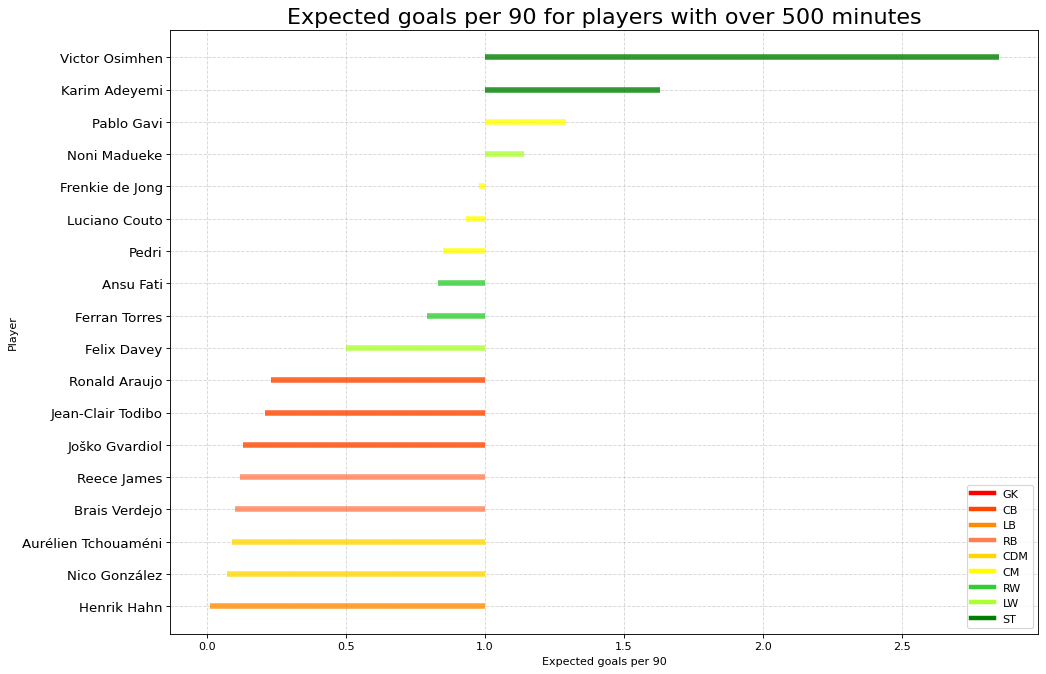

In [61]:
pie_chart('Goals', pull_out=1, width=1000)
bar_plot('Goals+xAp90')
diverging_bars('xGp90')
scatter_chart('xAp90', 'xGp90')
scatter_chart('PossessionWonp90', 'PossessionLostp90')
scatter_chart('PossessionWonp90', 'Goals+xAp90')
grouped_bar('Goalsp90', 'xGp90')
bar_plot('PossessionWonp90')